In [32]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Imports de la libreria propia
from vecopsciml.kernels.derivative import DerivativeKernels
from vecopsciml.utils import TensOps

# Imports de las funciones creadas para este programa
from models.non_constant_diffusivity import NonConstantDiffusivityNeuralNetwork
from utils.folders import create_folder
from utils.load_data import load_data
from trainers.train import train_loop

In [95]:
# Creamos los paths para las distintas carpetas
ROOT_PATH = r'C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning'
DATA_PATH = os.path.join(ROOT_PATH, r'data\non_linear\non_linear_fft_tests.pkl')
RESULTS_FOLDER_PATH = os.path.join(ROOT_PATH, r'results\non_linear')
# MODEL_RESULTS_PATH = os.path.join(ROOT_PATH, r'results\non_linear\model_paper')

# Creamos las carpetas que sean necesarias (si ya están creadas se avisará de ello)
create_folder(RESULTS_FOLDER_PATH)
# create_folder(MODEL_RESULTS_PATH)

Folder already exists at: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\results\non_linear


In [96]:
# Load dataset
dataset = load_data(DATA_PATH)

Data successfully loaded from: C:\Users\usuario\Desktop\rmunozTMELab\Physically-Guided-Machine-Learning\data\non_linear\non_linear_fft_tests.pkl


In [97]:
# Convolutional filters to derivate
dx = dataset['x_step_size']
dy = dataset['y_step_size']
D = DerivativeKernels(dx, dy, 0).grad_kernels_two_dimensions()

In [98]:
u = torch.Tensor(dataset['y_train'])
image = u

In [99]:
from collections import Counter

In [100]:
############################## LA CELDA DE ABAJO ES LA BUENA

In [101]:
def decompose_most_energetic_modes(data, n_modes):

    # FFT decomposition and obtain energy of each mode
    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)
    energy = torch.abs(fft_data_shifted)
    energy_flattened = energy.flatten(1, 2)

    # Get the n_modes more energetic modes and their indices
    top_energetic = torch.topk(energy_flattened, n_modes).indices
    top_energetic_indices, _ = zip(*Counter(top_energetic.flatten()).most_common(n_modes))

    top_energetic_indices = list(map(int, top_energetic_indices))

    coefs = fft_data_shifted.flatten(1, 2)[:, top_energetic_indices]

    return top_energetic_indices, coefs

def reconstruct_filtered_FFT(fft_coeficients, top_energetic_indices, data):

    filtered_modes = torch.zeros_like(data.flatten(1, 2), dtype=torch.complex64)
    filtered_modes[:, top_energetic_indices] = fft_coeficients

    # Reshape filtered modes and reconstruct image
    filtered_modes_base_fft_shifted =  filtered_modes.reshape(data.shape)
    filtered_modes_base = torch.fft.ifftshift(filtered_modes_base_fft_shifted)

    reconstructed_data = torch.real(torch.fft.ifft2(filtered_modes_base)) 

    return reconstructed_data


In [102]:
def decompose_and_compose_FFT(data, n_modes):

    # FFT decomposition and obtain energy of each mode
    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)
    energy = torch.abs(fft_data_shifted)
    energy_flattened = energy.flatten(1, 2)

    # Get the n_modes more energetic modes and their indices
    top_energetic = torch.topk(energy_flattened, n_modes).indices
    top_energetic_indices, _ = zip(*Counter(top_energetic.flatten()).most_common(n_modes))

    top_energetic_indices = list(map(int, top_energetic_indices))

    # Now we create a new tensor and we copy in it the modes that haven't been filtered
    filtered_modes = torch.zeros_like(energy_flattened, dtype=torch.complex64)
    filtered_modes[:, top_energetic_indices] = fft_data_shifted.flatten(1, 2)[:, top_energetic_indices]

    # Reshape filtered modes and reconstruct image
    filtered_modes_base_fft_shifted =  filtered_modes.reshape(data.shape)
    filtered_modes_base = torch.fft.ifftshift(filtered_modes_base_fft_shifted)

    reconstructed_data = torch.real(torch.fft.ifft2(filtered_modes_base))

    return reconstructed_data


In [103]:
import matplotlib.pyplot as plt
import torch
from mpl_toolkits.axes_grid1 import make_axes_locatable

index = 0
original = u[index]
reconstructed = decompose_and_compose_FFT(u, 200)[index]

def plot_images(original, filtered):
    plt.figure(figsize=(18, 6))  # Ampliar la figura para más espacio entre imágenes
    
    # Primer subplot (Imagen Original)
    ax1 = plt.subplot(1, 3, 1)
    im1 = ax1.imshow(original)
    ax1.set_title('Imagen Original', fontsize=12)
    ax1.axis('off')
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im1, cax=cax1)
    
    # Segundo subplot (Imagen con 5 Frecuencias Más Energéticas)
    ax2 = plt.subplot(1, 3, 2)
    im2 = ax2.imshow(filtered)
    ax2.set_title('Imagen con 5 Frecuencias Más Energéticas', fontsize=12)
    ax2.axis('off')
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax2)
    
    # Tercer subplot (Diferencia entre Original y Filtrada)
    ax3 = plt.subplot(1, 3, 3)
    im3 = ax3.imshow(torch.abs(original - filtered))
    ax3.set_title('Diferencia (5 Frecuencias Más Energéticas)', fontsize=12)
    ax3.axis('off')
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im3, cax=cax3)

    plt.tight_layout()
    plt.show()

    # Cálculo de la suma de diferencias normalizada
    print(torch.sum(torch.abs(original - filtered)/torch.abs(original - filtered)))

plot_images(original, reconstructed)

RuntimeError: selected index k out of range

In [104]:
def get_modes_base_and_coeficients(data, n_modes):

    # FFT decomposition and obtain energy of each mode
    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)
    energy = torch.abs(fft_data_shifted)
    energy_flattened = energy.flatten(1, 2)

    # Get the n_modes more energetic modes and their indices
    top_energetic = torch.topk(energy_flattened, n_modes).indices
    top_energetic_indices, _ = zip(*Counter(top_energetic.flatten()).most_common(n_modes))

    # Get base and coefficients
    modes_base = list(map(int, top_energetic_indices))
    coeficients = fft_data_shifted.flatten(1, 2)[:, top_energetic_indices]

    return coeficients, modes_base


def reconstruct_data_fft(coeficients, base, data_shape):

    # Create the new tensor to allocate filtered modes
    filtered_modes = torch.zeros((data_shape[0], data_shape[1]*data_shape[2]), dtype=torch.complex64)
    filtered_modes[:, base] = coeficients

    # Reshape filtered modes and reconstruct image
    filtered_modes_base_fft_shifted =  filtered_modes.reshape(data_shape)
    filtered_modes_base = torch.fft.ifftshift(filtered_modes_base_fft_shifted)

    reconstructed_data = torch.real(torch.fft.ifft2(filtered_modes_base)) 

    return reconstructed_data

In [105]:
# Lista para almacenar los resultados de máximo, mediana y mínimo
max_list = []
median_list = []
min_list = []

u_original = torch.Tensor(dataset['y_train'])

for i in range(1, u_original.shape[1] * u_original.shape[2]):

    u_original = torch.Tensor(dataset['y_train'])
    u_coeficients, u_modes_base = get_modes_base_and_coeficients(u_original, i)
    u_reconstructed = reconstruct_data_fft(u_coeficients, u_modes_base, u_original.shape)
    
    prediction_error = np.sqrt((np.trapz(np.trapz((u_original - u_reconstructed)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((u_original)**2, dx=dy),  dx=dx)))
    
    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    max_list.append(maximo)
    median_list.append(mediana)
    min_list.append(minimo)

    n_modes = i

    if tercer_cuartil < 1e-2:
        print("n modes = ", n_modes)
        print(f"Mínimo: {minimo:.2e}")
        print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
        print(f"Mediana (Q2): {mediana:.2e}")
        print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")
        print(f"Máximo: {maximo:.2e}")

        break

n modes =  19
Mínimo: 2.05e-05
Primer cuartil (Q1): 2.10e-03
Mediana (Q2): 4.73e-03
Tercer cuartil (Q3): 9.13e-03
Máximo: 3.21e-02


In [106]:
u_original = torch.Tensor(dataset['y_train'])
u_coeficients, u_modes_base = get_modes_base_and_coeficients(u_original, n_modes)
u_reconstructed = reconstruct_data_fft(u_coeficients, u_modes_base, u_original.shape)

def relative_error_stats(validation, prediction, dx=dx, dy=dy):

    validation = validation.numpy()
    prediction = prediction.numpy()

    prediction_error = np.sqrt((np.trapz(np.trapz((validation - prediction)**2, dx=dy), dx=dx) /
                                np.trapz(np.trapz((validation)**2, dx=dy), dx=dx)))

    minimo = np.min(prediction_error)
    maximo = np.max(prediction_error)
    primer_cuartil = np.percentile(prediction_error, 25)
    mediana = np.percentile(prediction_error, 50)
    tercer_cuartil = np.percentile(prediction_error, 75)

    # Imprimir los resultados
    print(f"Mínimo: {minimo:.2e}")
    print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
    print(f"Mediana (Q2): {mediana:.2e}")
    print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")
    print(f"Máximo: {maximo:.2e}")

relative_error_stats(u_original, u_reconstructed, dx=dx, dy=dy)

Mínimo: 2.05e-05
Primer cuartil (Q1): 2.10e-03
Mediana (Q2): 4.73e-03
Tercer cuartil (Q3): 9.13e-03
Máximo: 3.21e-02


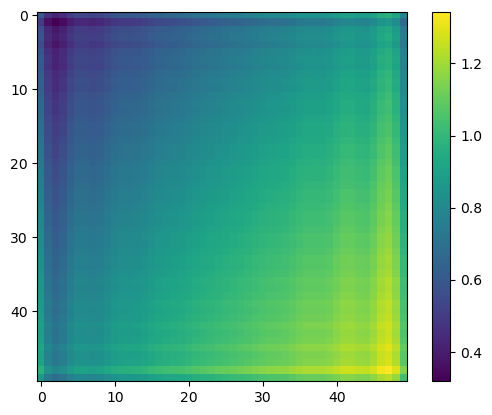

tensor(0.0120)


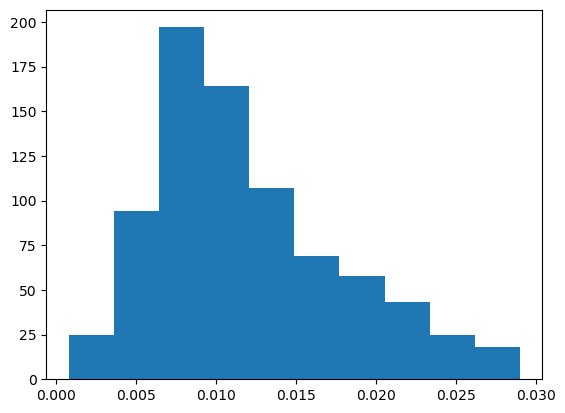

In [55]:
# Hayo los coeficientes de fourier mas energeticos
fft_img = torch.fft.fft2(image)
fft_img_shifted = torch.fft.fftshift(fft_img)
magnitude = torch.abs(fft_img_shifted)
magnitude_flattened = magnitude.flatten(1, 2)

# Me quedo con los 10 mas energeticos
k=50
top = torch.topk(magnitude_flattened, k).indices
values, counts = zip(*Counter(top.flatten()).most_common(k))

values_list = list(map(int, values))
counts_list = list(counts)

top_indices = values_list

nuevo_tensor = torch.zeros_like(magnitude_flattened, dtype=torch.complex64)
nuevo_tensor[:, top_indices] = fft_img_shifted.flatten(1, 2)[:, top_indices]

new_base_fft = nuevo_tensor.reshape(image.shape)

fft_filtered_shifted_back = torch.fft.ifftshift(new_base_fft)

img_filtered = torch.fft.ifft2(fft_filtered_shifted_back)

img_filtered = torch.real(img_filtered)

plt.imshow(img_filtered[0])
plt.colorbar()
plt.show()

error = torch.trapz(torch.trapz(torch.abs(img_filtered - image), dx=dx, dim=-1), dx=dx, dim=-1)/torch.trapz(torch.trapz(torch.abs(image), dx=dx, dim=-1), dx=dx, dim=-1)

print(torch.sum(error)/len(error))

plt.hist(error)
plt.show()


In [ ]:
# Función para conservar solo las 5 frecuencias más energéticas
def keep_top_k_frequencies(image, k=10):
    # Convertir la imagen a tensor de PyTorch
    img_tensor = image
    
    # Aplicar la transformada de Fourier 2D
    fft_img = torch.fft.fft2(img_tensor)
    
    # Desplazar el espectro de Fourier para centrar las frecuencias bajas
    fft_img_shifted = torch.fft.fftshift(fft_img)

    # Calcular la magnitud (energía) de las frecuencias
    magnitude = torch.abs(fft_img_shifted)
    
    # Aplanar la magnitud y obtener los índices de las top-k frecuencias más energéticas
    flat_magnitude = magnitude.flatten()
    top_k_indices = torch.topk(flat_magnitude, k).indices

    # Crear una máscara con ceros
    mask = torch.zeros_like(fft_img_shifted, dtype=torch.complex64)
    
    # Usar los índices para mantener solo las 5 frecuencias más energéticas
    for idx in top_k_indices:
        # Convertir el índice plano en coordenadas 2D
        i, j = np.unravel_index(idx.item(), fft_img_shifted.shape)
        mask[i, j] = 1.0  # Dejar pasar solo estas frecuencias

    # Aplicar la máscara
    fft_filtered = fft_img_shifted * mask
    
    # Invertir el desplazamiento del espectro
    fft_filtered_shifted_back = torch.fft.ifftshift(fft_filtered)
    
    # Aplicar la transformada inversa de Fourier
    img_filtered = torch.fft.ifft2(fft_filtered_shifted_back)
    
    # Tomar solo la parte real de la imagen filtrada
    img_filtered = torch.real(img_filtered)

    return img_filtered

# Función para mostrar la imagen original y filtrada
def plot_images(original, filtered):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Imagen Original')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(filtered)
    plt.title('Imagen con 5 Frecuencias Más Energéticas')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(torch.abs(original - filtered))
    plt.title('Imagen con 5 Frecuencias Más Energéticas')
    plt.colorbar()
    plt.axis('off')

    plt.show()

    print(torch.sum(torch.abs(original - filtered))/torch.sum(original))


# Cargar la imagen
img_path = 'ruta/a/tu/imagen.jpg'
image = u[0]

# Conservar solo las 5 frecuencias más energéticas
filtered_image = keep_top_k_frequencies(image, k=100)

# Mostrar las imágeness
plot_images(image, filtered_image.numpy())

In [486]:
f_coef = torch.fft.fft2(u)
F_ordered = f_coef.flatten(start_dim=1)
N = F_ordered.shape[1]

Et = torch.sum(torch.sum(torch.square(torch.abs(u)), dim=1), dim=1)
Ef = torch.sum(torch.sum(torch.square(torch.abs(f_coef)), dim=1), dim=1)/N

In [ ]:
f_coef = torch.fft.fft2(u)

columna = f_coef[:, :, 0]
fila = f_coef[:, 0, :]

nuevo = torch.zeros_like(f_coef, dtype=torch.complex64)
nuevo[:, :, 0] = columna
nuevo[:, 0, :] = fila



# Aplicar la transformada inversa de Fourier
img_filtered = torch.fft.ifft2(nuevo)

# Tomar solo la parte real de la imagen filtrada
img_filtered = torch.real(img_filtered)

plt.imshow((img_filtered)[429])
plt.colorbar()
plt.show()


In [ ]:
def fft_coeficients(data, n_modes):

    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)

    N_data, h, w = data.shape
    center_h, center_w = h // 2, w // 2

    mask = torch.zeros_like(fft_data_shifted, dtype=torch.complex64)

    for i in range(-n_modes // 2, n_modes // 2 + 1):
        for j in range(-n_modes // 2, n_modes // 2 + 1):
            if 0 <= center_h + i < h and 0 <= center_w + j < w:
                mask[:, center_h + i, center_w + j] = fft_data_shifted[:, center_h + i, center_w + j]

    filtered_fft_data_shifted = fft_data_shifted * mask

    return filtered_fft_data_shifted

def fft_coeficients_to_tensor(fft_coeficients):







In [ ]:
def relevant_modes_fft_coef(data, n_modes):
    
    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)

    N_data, h, w = data.shape
    center_h, center_w = h // 2, w // 2

    mask = torch.zeros((N_data, n_modes + 1, n_modes + 1), dtype=torch.complex64)

    for i in range(-n_modes // 2, n_modes // 2 + 1):
        for j in range(-n_modes // 2, n_modes // 2 + 1):
            mask[:, i + n_modes // 2, j + n_modes // 2] = fft_data_shifted[:, center_h + i, center_w + j]

    return mask


def reconstruct_relevant_modes(relevant_modes_fft_coef, shape):

    N_data, h, w = shape
    center_h, center_w = h // 2, w // 2
    n_modes = relevant_modes_fft_coef.shape[1] - 1

    reconstruction = torch.zeros((N_data, h, w), dtype=torch.complex64)

    for i in range(-n_modes // 2, n_modes // 2 + 1):
        for j in range(-n_modes // 2, n_modes // 2 + 1):
             reconstruction[:, center_h + i, center_w + j] = relevant_modes_fft_coef[:, i + n_modes // 2, j + n_modes // 2]

    return torch.fft.ifft2(torch.fft.fftshift(reconstruction)).real



a = relevant_modes_fft_coef(u, 49)
u_recon = reconstruct_relevant_modes(relevant_modes_fft_coef(u, 49), u.shape)

plt.imshow(u_recon[0])

In [ ]:
def error_images(data, n_modes):

    time_start = time.time()  # Use a different variable name for the start time

    fft_data = torch.fft.fft2(data)
    fft_data_shifted = torch.fft.fftshift(fft_data)

    N_data, h, w = data.shape
    center_h, center_w = h // 2, w // 2

    mask = torch.zeros_like(fft_data_shifted, dtype=torch.complex64)

    for data_i in range(N_data):
        for i in range(-n_modes//2, n_modes//2 + 1):
            for j in range(-n_modes//2, n_modes//2 + 1):
                if 0 <= center_h + i < h and 0 <= center_w + j < w:
                    mask[data_i, center_h + i, center_w + j] = fft_data_shifted[data_i, center_h + i, center_w + j]

    
    time_end = time.time()  # Use a different variable name for the end time

    print(time_end - time_start)  # Print the elapsed time



    # Create a mask and filter low-energetic modes
    mask = torch.zeros_like(fft_coef_shifted, dtype=torch.complex64)

    for img_idx in range(data.shape[0]):
        for idx in top_energy_indices[img_idx]:
            i, j = np.unravel_index(idx.item(), data.shape[1:])  
            mask[img_idx, i, j] = 1.0 

error_images(u, 5)

In [ ]:
# Función para conservar solo las 5 frecuencias más energéticas
def keep_top_k_frequencies(image, k=10):
    # Convertir la imagen a tensor de PyTorch
    img_tensor = image
    
    # Aplicar la transformada de Fourier 2D
    
    
    # Desplazar el espectro de Fourier para centrar las frecuencias bajas
    

    # Calcular la magnitud (energía) de las frecuencias
    magnitude = torch.abs(fft_img_shifted)
    
    # Aplanar la magnitud y obtener los índices de las top-k frecuencias más energéticas
    flat_magnitude = magnitude.flatten()
    top_k_indices = torch.topk(flat_magnitude, k).indices

    # Crear una máscara con ceros
    mask = torch.zeros_like(fft_img_shifted, dtype=torch.complex64)
    
    # Usar los índices para mantener solo las 5 frecuencias más energéticas
    for idx in top_k_indices:
        # Convertir el índice plano en coordenadas 2D
        i, j = np.unravel_index(idx.item(), fft_img_shifted.shape)
        mask[i, j] = 1.0  # Dejar pasar solo estas frecuencias

    # Aplicar la máscara
    fft_filtered = fft_img_shifted * mask
    
    # Invertir el desplazamiento del espectro
    fft_filtered_shifted_back = 
    
    # Aplicar la transformada inversa de Fourier
    
    
    # Tomar solo la parte real de la imagen filtrada
    img_filtered = torch.real(img_filtered)

    return img_filtered

In [ ]:
u

In [ ]:
U, S, V = torch.svd()

In [ ]:
energy = []

for index in range(Et.shape[0]):
    energy.append(torch.sum(torch.sum(torch.square(torch.abs(F_ordered[index, :10]))))/N/Et[index])

minimo = np.min(energy)
maximo = np.max(energy)
primer_cuartil = np.percentile(energy, 25)
mediana = np.percentile(energy, 50)
tercer_cuartil = np.percentile(energy, 75)

# Imprimir los resultados
print(f"Máximo: {maximo:.2e}")
print(f"Tercer cuartil (Q3): {tercer_cuartil:.2e}")
print(f"Mediana (Q2): {mediana:.2e}")
print(f"Primer cuartil (Q1): {primer_cuartil:.2e}")
print(f"Mínimo: {minimo:.2e}\n")

minimo = np.min(energy)
indice_minimo = np.argmin(energy)

print(f"El valor mínimo es: {minimo}")
print(f"El índice del valor mínimo es: {indice_minimo}")

In [ ]:
mask = np.zeros_like(F_ordered)
mask[:, :50] = 1

F_full = f_coef*mask.reshape(f_coef.shape)
u_reconstructed = torch.fft.ifft2(F_full).real

print(torch.sum(torch.abs(u - u_reconstructed))/torch.sum(torch.abs(u)))

plt.imshow(F_full[0].real)
plt.colorbar()

In [ ]:
index = 429

plt.imshow(u[index])
plt.colorbar()
plt.show()

plt.imshow(u_reconstructed[index])
plt.colorbar()
plt.show()

plt.imshow(np.abs(u_reconstructed[index] - u[index]))
plt.colorbar()
plt.show()

In [12]:
def coef_to_tensor(coefs):

    filtered_coefficients_list = []

    for img_idx in range(coefs.shape[0]):
        non_zero_coefs = coefs[img_idx][coefs[img_idx] != 0]  # Filtrar coeficientes no nulos
        filtered_coefficients_list.append(non_zero_coefs)

    # Convertir la lista en un tensor de objetos PyTorch
    filtered_coefficients_tensor = torch.stack([torch.tensor(coefs) for coefs in filtered_coefficients_list])

    print(filtered_coefficients_tensor)

In [ ]:
def decompose_data_FFT(data, n_components):

    # Forward FFT
    fft_coef = torch.fft.fft2(data)
    fft_coef_shifted = torch.fft.fftshift(fft_coef, dim=(-2, -1))
    
    # Obtain most energetic modes
    energy = torch.abs(fft_coef_shifted)
    flat_energy = energy.view(data.shape[0], -1) 
    top_energy_indices = torch.topk(flat_energy, n_components, dim=1).indices

    print(top_energy_indices[:, 0:5])

    # Create a mask and filter low-energetic modes
    mask = torch.zeros_like(fft_coef_shifted, dtype=torch.complex64)

    for img_idx in range(data.shape[0]):
        for idx in top_energy_indices[img_idx]:
            i, j = np.unravel_index(idx.item(), data.shape[1:])  
            mask[img_idx, i, j] = 1.0 

    fft_coef_filtered = fft_coef_shifted * mask

    return fft_coef_filtered

def compose_data_FFT(fft_coef_shifted_filtered):

    # Backward FFT
    fft_filtered_shifted_back = torch.fft.ifftshift(fft_coef_shifted_filtered, dim=(-2, -1))
    data_filtered = torch.fft.ifft2(fft_filtered_shifted_back)
    data_filtered_real = torch.real(data_filtered)

    return data_filtered_real



index = 429
filtered = decompose_data_FFT(u, 50)[index].real
original = u[index]


plt.figure(figsize=(12, 6))
    
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title('Imagen Original')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(filtered)
plt.title('Imagen con 5 Frecuencias Más Energéticas')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(torch.abs(original - filtered))
plt.title('Imagen con 5 Frecuencias Más Energéticas')
plt.colorbar()
plt.axis('off')

plt.show()



In [ ]:
# Función para conservar solo las 5 frecuencias más energéticas
def keep_top_k_frequencies(image, k=10):
    # Convertir la imagen a tensor de PyTorch
    img_tensor = image
    
    # Aplicar la transformada de Fourier 2D
    fft_img = torch.fft.fft2(img_tensor)
    
    # Desplazar el espectro de Fourier para centrar las frecuencias bajas
    fft_img_shifted = torch.fft.fftshift(fft_img)

    # Calcular la magnitud (energía) de las frecuencias
    magnitude = torch.abs(fft_img_shifted)
    
    # Aplanar la magnitud y obtener los índices de las top-k frecuencias más energéticas
    flat_magnitude = magnitude.flatten()
    top_k_indices = torch.topk(flat_magnitude, k).indices

    # Crear una máscara con ceros
    mask = torch.zeros_like(fft_img_shifted, dtype=torch.complex64)
    
    # Usar los índices para mantener solo las 5 frecuencias más energéticas
    for idx in top_k_indices:
        # Convertir el índice plano en coordenadas 2D
        i, j = np.unravel_index(idx.item(), fft_img_shifted.shape)
        mask[i, j] = 1.0  # Dejar pasar solo estas frecuencias

    # Aplicar la máscara
    fft_filtered = fft_img_shifted * mask
    
    # Invertir el desplazamiento del espectro
    fft_filtered_shifted_back = torch.fft.ifftshift(fft_filtered)
    
    # Aplicar la transformada inversa de Fourier
    img_filtered = torch.fft.ifft2(fft_filtered_shifted_back)
    
    # Tomar solo la parte real de la imagen filtrada
    img_filtered = torch.real(img_filtered)

    return img_filtered

# Función para mostrar la imagen original y filtrada
def plot_images(original, filtered):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title('Imagen Original')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(filtered)
    plt.title('Imagen con 5 Frecuencias Más Energéticas')
    plt.colorbar()
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(torch.abs(original - filtered))
    plt.title('Imagen con 5 Frecuencias Más Energéticas')
    plt.colorbar()
    plt.axis('off')

    plt.show()

    print(torch.sum(torch.abs(original - filtered))/torch.sum(original))


# Cargar la imagen
img_path = 'ruta/a/tu/imagen.jpg'
image = u[429]

# Conservar solo las 5 frecuencias más energéticas
filtered_image = keep_top_k_frequencies(image, k=50)

# Mostrar las imágeness
plot_images(image, filtered_image.numpy())